# Setup

In [ ]:
!pip install livelossplot

import pandas as pd
import numpy as np
import zipfile
import random
from livelossplot import PlotLossesKeras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 9.3 MB/s 
     |████████████████████████████████| 381 kB 39.1 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.30 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.34.0 which is incompatible.


* Import dataset from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zipped_dataset = '/content/drive/MyDrive/A_Progetti/AlgoForMassiveDatasets/dataset.zip'

Mounted at /content/drive


* Import dataset from Kaggle

In [ ]:
!pip install kaggle

import os

#insert token username
os.environ['KAGGLE_USERNAME'] = 'k4ggl3gpu'
#insert token key
os.environ['KAGGLE_KEY'] = 'b351711c9f4e2907c33cbf94a533e17b'

!kaggle datasets download -d k4ggl3gpu/algorithmsformassivedataset20212022dataset

zipped_dataset = '/content/algorithmsformassivedataset20212022dataset.zip'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 99% 641M/647M [00:07<00:00, 113MB/s]
100% 647M/647M [00:07<00:00, 86.7MB/s]


* Unzip and check dataset

In [ ]:
zf = zipfile.ZipFile(zipped_dataset)

#Check all files inside zip folder
print(zf.namelist())
#Open and read csv file
df_dataset = pd.read_csv(zf.open('dataset.csv'), header=None)
df_dataset = df_dataset.astype('string')
df_dataset = df_dataset.fillna('')

print(df_dataset.dtypes)
print(df_dataset.info())
print(df_dataset.sample(10))

['dataset.csv']
0    string
1    string
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26700388 entries, 0 to 26700387
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   0       string
 1   1       string
dtypes: string(2)
memory usage: 407.4 MB
None
                                                          0                  1
16315986  targets operation striking lavrov civilian slo...           0 1 2 18
470124    hristo stolen 2014 however money flowers russi...                0 1
9092640   lie blood hundreds killed children state telet...               1 66
10767983                                            morning                  0
3770916   longer companies belarusian russian kick yeste...            1 33 59
6350701          work cat home keeping motivated helps love                 16
25183899  defenses air ka 52 rf ukrainian war destroyed ...                  1
2813315   gop son reveals never mentioned publicly senat...               

* Most frequent hashtags list

In [ ]:
TOP_HASHTAGS = ['ukraine', 'russia', 'standwithukraine', 'putin', 'russian', 'mariupol', 'news', 'azovstal', 'ukrainerussianwar', 'ukrainian', 'nato', 'ukrainewar', 'ukraine️', 'business', 'ukrainerussiawar', 'kharkiv', 'usa', 'tigray', 'armukrainenow', 'kyiv', 'russianukrainianwar', 'stoprussia', 'slavaukraini', 'standwithukraine️', 'stopputinnow', 'stopputin', 'war', 'russiaukrainewar', 'savemariupol', 'zelenskyy', 'anonymous', 'biden', 'russians', 'eu', 'ukraineunderattaсk', 'kherson', 'standwithukriane', 'scotus', 'helpukraine', 'russianwarcrimes', 'tigraygenocide', 'us', 'nft', 'china', 'zelenskiynft', 'zelensky', 'endtigraysiege', 'safeairliftukraine', 'azov', 'giveaway', 'europe', 'ukraineunderattack', 'oprussia', 'donbass', 'canada', 'bucha', 'moscow', 'nfts', 'syria', 'poland', 'uk', 'russiaukraine', 'breaking', 'india', 'odesa', 'germany', 'ukrainians', 'russianarmy', 'donetsk', 'putinwarcrimes', 'mykolaiv', 'ukrainerussia', 'belarus', 'warcrimes', 'kiev', 'healthy', 'healthyeating', 'donbas', 'ukraineinvasion', 'breakingnews', 'roevwade', 'united24', 'luhansk', 'peace', 'stoprussianaggression', 'supportukraine', 'severodonetsk', 'putinwarcriminal', 'odessa', 'crypto', 'irpin', 'bitcoin', 'noflyzone', 'moskva', 'trump', 'closethesky', 'product', 'freeshipping', 'russiaukraineconflict', 'warinukraine']

# Configuration parameters

* Fine tune neural networks

In [ ]:
#Slice of dataset to use
first_tweet = 5000000
last_tweet = 5750000

#Embedding neural network parameters
embedding_neural_network_vectorization_layer_output_tokens = 50
embedding_neural_network_words_dictionary_size = 10000
embedding_neural_network_words_embedding_dimensions = int(embedding_neural_network_words_dictionary_size ** 0.25)

#Embedding neural network to process input data

* Embedding neural network input layer

In [ ]:
embedding_neural_network_input_layer = tf.keras.layers.InputLayer(
    input_shape=(1,1),
    dtype=tf.string
    )

* Embedding neural network text vectorization layer

In [ ]:
embedding_neural_network_text_vectorization_layer = tf.keras.layers.TextVectorization(
    max_tokens=embedding_neural_network_words_dictionary_size, #Limits learned vocabulary to top 10000 most frequent tokens
    standardize='lower_and_strip_punctuation', #All words become lowercase and punctuation is removed
    split='whitespace', #Splits input string into tokens using whitespace as delimiter
    output_mode='int', #Output encoding type
    output_sequence_length=embedding_neural_network_vectorization_layer_output_tokens #Number of output tokens
    )

embedding_neural_network_text_vectorization_layer.adapt(df_dataset.iloc[first_tweet:last_tweet, 0:1])

embedding_neural_network_vectorization_layer_vocabulary_lenght = len(embedding_neural_network_text_vectorization_layer.get_vocabulary())

* Embedding neural network embedding layer

In [ ]:
embedding_neural_network_embedding_layer = tf.keras.layers.Embedding(
    input_dim=embedding_neural_network_vectorization_layer_vocabulary_lenght,
    output_dim=embedding_neural_network_words_embedding_dimensions,
    input_length=embedding_neural_network_vectorization_layer_output_tokens
    )

* Embedding neural network flattening layer

In [ ]:
embedding_neural_network_flattening_layer = tf.keras.layers.Flatten()

* Embedding neural network model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1, 50)            0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1, 50, 10)         100000    
                                                                 
 flatten (Flatten)           (None, 500)               0         
                                                                 
Total params: 100,000
Trainable params: 100,000
Non-trainable params: 0
_________________________________________________________________


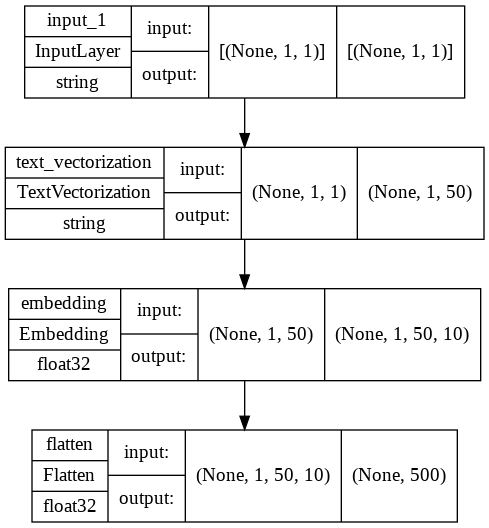

In [ ]:
embedding_neural_network = tf.keras.Sequential([
                             embedding_neural_network_input_layer,
                             embedding_neural_network_text_vectorization_layer,
                             embedding_neural_network_embedding_layer,
                             embedding_neural_network_flattening_layer,
                             #tf.keras.layers.GlobalAveragePooling2D()
                             ])

embedding_neural_network.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy']
    )

embedding_neural_network.summary()

tf.keras.utils.plot_model(
    embedding_neural_network,
    to_file="Embedding neural network.png", 
    show_shapes=True, 
    show_dtype=True, 
    show_layer_names=True, 
    show_layer_activations=True
    )

* Embedding neural network output used as input for the forecasting neural network

In [ ]:
forecasting_neural_network_input_data = embedding_neural_network.predict(df_dataset.iloc[first_tweet:last_tweet, 0:1])

# Expected output labels decompression

* Labels decompressing function

In [ ]:
#Expand second column of dataset
def from_indices_to_boolean_vector(indices):
    indices = str(indices.values[0])
    pads = [0 for _ in range(len(TOP_HASHTAGS))]
    if not indices:
      return pads
    indices = [int(x) for x in indices.split(' ')]
    for index in indices:
      pads[index] = 1
    return pads

* Labels decompressed as expected output for the forecasting neural network

In [ ]:
forecasting_neural_network_expected_output_labels = df_dataset.iloc[first_tweet:last_tweet, 1:2].apply(from_indices_to_boolean_vector, axis=1, result_type='expand')

# Forecasting neural network

* Forecasting neural network input and output shapes

In [ ]:
forecasting_neural_network_input_shape = forecasting_neural_network_input_data.shape[1]
forecasting_neural_network_output_shape = len(TOP_HASHTAGS)

* Forecasting neural network input layer

In [ ]:
forecasting_neural_network_input_layer = tf.keras.layers.InputLayer(
    input_shape=(forecasting_neural_network_input_shape),
    )

* Forecasting neural network model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 250)               125250    
                                                                 
 dense_1 (Dense)             (None, 125)               31375     
                                                                 
 dense_2 (Dense)             (None, 100)               12600     
                                                                 
Total params: 169,225
Trainable params: 169,225
Non-trainable params: 0
_________________________________________________________________


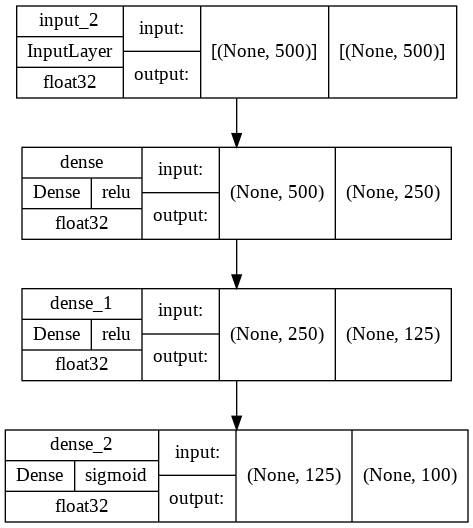

In [ ]:
forecasting_neural_network = tf.keras.Sequential([
                          forecasting_neural_network_input_layer,
                          #tf.keras.layers.Dense(256, activation='relu'),   
                          #tf.keras.layers.Dense(128, activation='relu'),
                          tf.keras.layers.Dense((forecasting_neural_network_input_shape / 2), activation='relu'),
                          tf.keras.layers.Dense((forecasting_neural_network_input_shape / 4), activation='relu'),
                          tf.keras.layers.Dense(forecasting_neural_network_output_shape, activation='sigmoid')
                          ])

forecasting_neural_network.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
    )

#forecasting_neural_network.build()

forecasting_neural_network.summary()

tf.keras.utils.plot_model(
    forecasting_neural_network,
    to_file="Forecasting neural network.png", 
    show_shapes=True, 
    show_dtype=True, 
    show_layer_names=True, 
    show_layer_activations=True
    )

# Training

* Split dataset into training and test data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(forecasting_neural_network_input_data, forecasting_neural_network_expected_output_labels, test_size=0.3, random_state=random.randint(0, 100))

* Forecasting neural network training

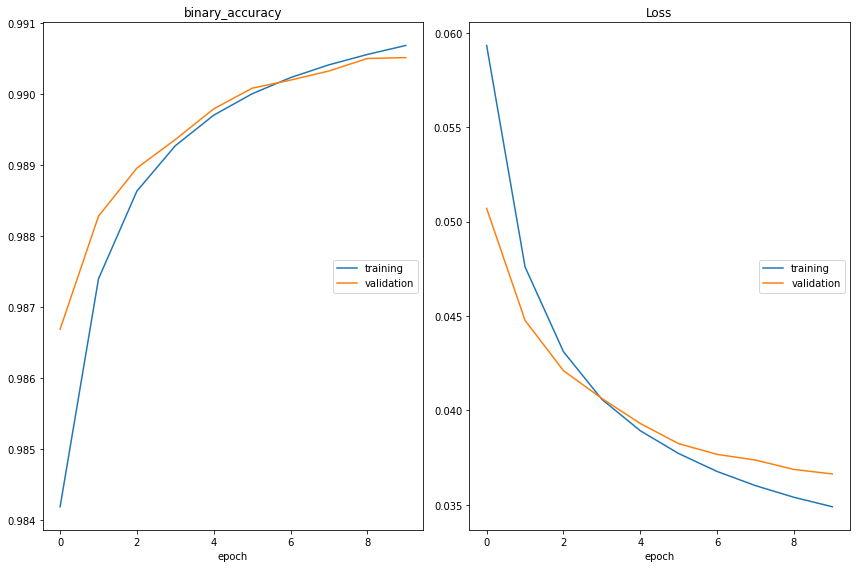

binary_accuracy
	training         	 (min:    0.984, max:    0.991, cur:    0.991)
	validation       	 (min:    0.987, max:    0.991, cur:    0.991)
Loss
	training         	 (min:    0.035, max:    0.059, cur:    0.035)
	validation       	 (min:    0.037, max:    0.051, cur:    0.037)
13125/13125 [==============================] - 55s 4ms/step - loss: 0.0349 - binary_accuracy: 0.9907 - val_loss: 0.0366 - val_binary_accuracy: 0.9905


In [ ]:
#Train model
forecasting_neural_network.fit(
    x=X_train, y=Y_train,
    validation_split=0.2,
    epochs=10,
    shuffle=True,
    callbacks=[PlotLossesKeras()]
    )

# Testing

* Forecasting neural network testing

In [ ]:
#Test model
forecasting_neural_network.evaluate(
    x=X_test, y=Y_test,
    )

7032/7032 [==============================] - 14s 2ms/step - loss: 0.0369 - binary_accuracy: 0.9904


[0.036899857223033905, 0.9904478192329407]